# CS 109A
# Final Project

# Will Cho, Haruka Uchida, Jessica Zhao


Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib import colors
import seaborn as sns
%matplotlib inline

In [2]:
#########################
### Read in Data ########
#########################

# if want to use ID number as the index, index_col = 'RID'
df = pd.read_csv('CS109a/Data_Database/ADNIMERGE.csv')
#df = pd.read_csv('CS109a/Data_Database/usethisdata.csv')

#################################
### Get all Column Names ########
#################################

all_variables_first = list(df.columns.values)

#################################
### Make Dummy Variables ########
#################################

# there are probably more categoricals need to add to this array
categorical_col = ['PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'PTMARRY','COLPROT']
df = pd.get_dummies(df, columns=categorical_col)
# make list of all variables, including dummy variables
all_variables_dum = list(df.columns.values)
len(all_variables_dum)

123

For the categorical variables of interest, binary indicator variables will be made. We will do so for gender, education, race, marital status, and the protocol under which the data was collected.

In [3]:
#gender baseline is male
#race baseline is white
#marriage baseline is never married
#Protocol under which data was collected (COLPROT) baseline is ADNIGO
dummies = ['PTGENDER_Female',
           'PTRACCAT_Am Indian/Alaskan',
         'PTRACCAT_Asian',
         'PTRACCAT_Black',
         'PTRACCAT_Hawaiian/Other PI',
         'PTRACCAT_More than one',
         'PTRACCAT_Unknown',
            'PTMARRY_Divorced',
         'PTMARRY_Married',
         'PTMARRY_Unknown',
         'PTMARRY_Widowed',
          'PTEDUCAT_12', 'PTEDUCAT_14',
          'PTEDUCAT_16','PTEDUCAT_18','PTEDUCAT_19',
 'PTEDUCAT_20', 'COLPROT_ADNI1', 'COLPROT_ADNI2', 'COLPROT_ADNI3']
#list(df.columns.values)

Currently our data is longitudinal and the variable 'DX_bl' records whether the patient has Alzheimers at the time of observation or not. However, we can take advantage of the fact that we know future visits of patients and create a binary variable that takes on value 1 if the patient ever ended up developing Alzheimers, and a value of 0 if the patient in the record history never ends up developing Alzheimers. This way, our predictor variable can predict the risk of developing Alzheimers: not just the probability of the patient having Alzheimers.

To create this variable, we can first code for each observation whether the patient was recorded as having Alzheimers or  not, as currently the 'DX_bl' variable also includes other forms of dememntia; we can create a binary variable ('alz_at_moment') that takes on value 1 if the observation is recorded to have Alzheimers, and 0 otherwise. Then, we can loop over the dataset for each unique patient ID, and create a new indicator variable ('got_alz') by taking the maximum of the Alzheimers indicator variable ('alz_at_moment') such that a patient who is recored to have ended up developing Alzheimers always has a value of 1 for this variable. Patients who are recorded to have not ended up developing Alzheimers have a value of 0.

In [4]:
#############################################
### Make Var for whether have Alz or not ####
#############################################

#currently the diagnosis variables = 1 if has any form of dementia
#want to make dummy variable for if they report having alzheimers (not any other type)

alz_at_moment = []
# for each observation in the dataset
for observation in range(len(df.index)):
    if df['DX_bl'][observation] == 'AD':
        alz_at_moment.append(1)
    else:
        alz_at_moment.append(0)
df['alz_at_moment'] = alz_at_moment

In [5]:
##########################################################
## Make Predictor Variable for Ever getting Alzheimers ###
##########################################################

# since data is longitudinal, will make a "did they ever get alzheimers" variable
got_alz = []
#for every unique patient
for name, group in df.groupby('PTID'):
    # list of patient's alzheimer dummy values (since longitudinal)
    unique_patient_alz = group['alz_at_moment'].values
    # get 'max' of alzheimers dummy
    # therefore those with max = 1 have reported getting alzheimers in their life
    # those with max = 0 never got alzheimers
    got_alz = got_alz + [max(unique_patient_alz)] * len(unique_patient_alz)

#add it to the dataframe
df['got_alz'] = got_alz

Although the age of the patient at the date of observation is not included in the dataset, we can create this variable using the given information, as the dataset includes the age of the patient at baseline, and the years from baseline of the observation. Therefore by adding the two, we can compute the age of the patient at the date of observation.

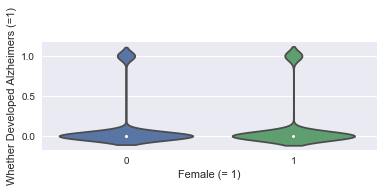

In [6]:
#################################################################
## Create Violin Plot after creating new Alzheimers Indicator ###
#################################################################

df_for_violin = df.copy()
# violin plot
plt.figure(figsize=(6, 2))
vio = sns.violinplot(x="PTGENDER_Female", y="got_alz", data=df_for_violin)
vio.set_ylabel('Whether Developed Alzheimers (=1)')
vio.set_xlabel('Female (= 1)')
label = [vio.set_xticklabels(vio.get_xticklabels())]
#labels = [item.get_text() for item in vio.get_xticklabels()]
#labels[0] = 'Male'
fig = vio.get_figure()

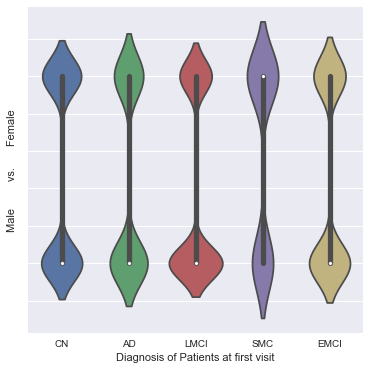

In [7]:
############################################
## Create Violin Plot for DX_bl Variable ###
############################################

plt.figure(figsize=(6, 6))
vio = sns.violinplot(y="PTGENDER_Female", x="DX_bl", data=df_for_violin)
vio.set_ylabel('Male         vs.       Female')
vio.set_xlabel('Diagnosis of Patients at first visit')
label = [vio.set_xticklabels(vio.get_xticklabels())]
ylabel = [vio.set_yticklabels(vio.get_yticklabels())]
#labels = [item.get_text() for item in vio.get_xticklabels()]
#labels[0] = 'Male'
fig = vio.get_figure()

In [8]:
for name, group in df.groupby('PTID'):
    if len(set(group['DX_bl'].values))>1:
        print(group['DX_bl'].values)
# since this prints nothing, there are no patients for who switch diagnosis in our longitudinal data

In [9]:
df.RID[df.DX_bl == None]
#there are no observations that are missing a diagnosis

Series([], Name: RID, dtype: int64)

In [10]:
######################################
### Make Age at Exam Date Variable ###
######################################

age_at_examdate = []
# for each observation in the dataset
for observation in range(len(df.index)):
    # age at exam date is 'age at base line' + 'years from baseline'
    age_at_examdate.append(df['AGE'][observation] + df['Years_bl'][observation])
df['age_at_examdate'] = age_at_examdate
#Now we can get rid of the 'years since baseline' variable

df['age_at_examdate'].describe()

count    13017.000000
mean        76.002485
std          7.384153
min         54.400000
25%         71.197125
50%         76.301027
75%         81.206090
max         98.602050
Name: age_at_examdate, dtype: float64

When splitting our data into training and test sets, we must keep into account the fact that the dataset is a longitudinal one. Therefore the same individual can show up in our dataset multiple times. The Participant ID (PTID) is unique for every participant, and therefore when splitting the training and test sets, we want to make sure that observations from the same participant are all in one of the test sets, not both. Therefore observations of a given participant should all be in either the test set or training set. Otherwise, if we include data from the same partipant in both the test and training set, our model could overfit to such participants.

Methodologically, threfore, when creating training and test sets, we wil randomly sample from the list of unique patient IDs to determine which participants will be used for the training set and which will be used for the test set.

We split the data before imputing, since we want to maintain the division of training and test data. Should we utilize imputation prior to the split, we would be using test data to determine imputation of training data, and vice versa. The test data should be considered a separate data set, for the sole purpose of testing on unknown data later on, after building the model. Thus, imputation should be done on the training and test sets separately.

In [11]:
##########################################
### Make Training and test dataframes ####
##########################################
#list of all unique Patient IDs
Unique_Patient_IDs = list(set(df['PTID']))
import random
np.random.seed(9001)
#randomize the order of the patients
np.random.shuffle(Unique_Patient_IDs)
#split the list of IDs to 2
split_IDs = np.split(np.array(Unique_Patient_IDs),2)
unique_ID_train = list(split_IDs[0])
unique_ID_test = list(split_IDs[1])

#make the train and test sets using the IDs
df_train = df[df['PTID'].isin(unique_ID_train)]
df_test = df[df['PTID'].isin(unique_ID_test)]
print(df_train.shape)
print(df_test.shape)

(6524, 126)
(6493, 126)


Many of our variables in the dataset have missing values. To address this, we will impute the missing values. We chose to impute rather than to remove the participants or predictors with missing values for two main reasons. The first main reason is that a majority of our predictors have missing values; therefore by simply removing predictors with missing values severely depletes our data and throws away valuable information about the patients. The second main reason is that the majority of participants have missing values for some of the predictors. Therefore removing observations with missing values is not practical to build a model. Another important aspect of removing missing values is that such a methodology makes sense when it is unlikely that the fact that the observation is missing is unrelated to the outcome variable. We cannot be sure of this since the fact that certain particpants are missing certain observations could be correlated with the outcome variable. For instance, perhaps those who are missing certain medical measurements reside in low income areas with poorly equipped hospitals. And perhaps Alzheimer's is more rampent in low income areas. Then, by deleting out participants with missing variables, we lose an important part of the story. Therefore we will refrain from this.

We approached imputation using two methods: imputing using a mean on the patient level, and imputing using a model for the entire sample. We imputed using both ways separately, and will compare results from both methods.

First, we impute using the mean. The below function loops over every unique participant ID in the dataset and imputes missing values of the variable of interest by taking the mean of the patient's other observations; if the patient does not have any observations for the variable of interest (all are nans), then they are left as nans. Therefore imputing using patient-level means does not entirely address the issue of missing values because while we will be able to impute values for patients who have historical data for the variable of interest, those with all missing values will still be left with nans.

# Mean Imputation

In [12]:
################################################################
## Impute Missing Values using Patient-Level Means: Function ###
################################################################
#function imputes using mean on participant level. returns a tuple
#[0] is number of participants who didn't get imputed (had all nan for var)
#[1] is string of imputed values (nan for those who had all nan)
def impute_by_patientID_mean(var_to_impute, data_frame):
    participants_with_all_na = 0
    imputed_var = []
    #for every unique patient
    for name, group in data_frame.groupby('PTID'):
        # list of patient's alzheimer dummy values (since longitudinal)
        unique_patient_var_values = group[str(var_to_impute)].values
        # take values that are not nan
        nonmissing_var_values = [i for i in unique_patient_var_values if not np.isnan(i)]
        #if there are values that are not nan
        if len(nonmissing_var_values)>0:
            #for each value of the actual data in the dataset, including nans
            for value in unique_patient_var_values:
                #if it is nan, dont change
                if np.isnan(value):
                    imputed_var.append(np.mean(np.asarray(nonmissing_var_values)))
                #if it is not nan, dont change
                else:
                    imputed_var.append(value)
        #if unique participant has no observations
        else:
            participants_with_all_na = participants_with_all_na +1
            #add nans
            for j in range(len(unique_patient_var_values)):
                imputed_var.append(np.nan)
    return((participants_with_all_na, imputed_var))

In [13]:
### testing number of participants who are missing all values of variable
print(df_train.shape)
list_var_to_impute = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
list_var_to_impute= list_var_to_impute + ['APOE4' , 'EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt']
list_var_to_impute = list_var_to_impute + ['CDRSB', 'ADAS11', 'MMSE', 'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ','MOCA']
print('number of patients who are entirely missing measures for each given measure:')
for variable_test in list_var_to_impute:
    print(variable_test, impute_by_patientID_mean(variable_test, df_train)[0])

(6524, 126)
number of patients who are entirely missing measures for each given measure:
Ventricles 28
Hippocampus 50
WholeBrain 23
Entorhinal 69
Fusiform 69
MidTemp 69
ICV 18
APOE4 22
EcogSPMem 272
EcogSPLang 272
EcogSPVisspat 275
EcogSPPlan 275
EcogSPOrgan 278
EcogSPDivatt 275
CDRSB 0
ADAS11 1
MMSE 0
RAVLT_immediate 3
RAVLT_learning 3
RAVLT_forgetting 3
RAVLT_perc_forgetting 5
FAQ 5
MOCA 280


In [14]:
####################################################################
## Impute Missing Values using Patient-Level Means: Training Set ###
####################################################################
df_mean_imputation_train = df_train.copy()
for variable_impute in list_var_to_impute:
    df_mean_imputation_train[str(variable_impute)] = impute_by_patientID_mean(variable_impute, df_train)[1]

################################################################
## Impute Missing Values using Patient-Level Means: Test Set ###
################################################################
df_mean_imputation_test = df_test.copy()
for variable_impute in list_var_to_impute:
    df_mean_imputation_test[str(variable_impute)] = impute_by_patientID_mean(variable_impute, df_test)[1]
df_mean_imputation_test.head()

,RID,PTID,VISCODE,SITE,ORIGPROT,EXAMDATE,DX_bl,AGE,PTETHCAT,APOE4,...,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,COLPROT_ADNI1,COLPROT_ADNI2,COLPROT_ADNI3,COLPROT_ADNIGO,alz_at_moment,got_alz,age_at_examdate
5,4,022_S_0004,bl,22,ADNI1,2005-11-08,LMCI,67.5,Hisp/Latino,2.0,...,0,0,0,1,0,0,0,0,0,67.500000
6,4,022_S_0004,m06,22,ADNI1,2006-05-02,LMCI,67.5,Hisp/Latino,2.0,...,0,0,0,1,0,0,0,0,0,67.979124
7,4,022_S_0004,m12,22,ADNI1,2006-11-14,LMCI,67.5,Hisp/Latino,2.0,...,0,0,0,1,0,0,0,0,0,68.515740
8,4,022_S_0004,m18,22,ADNI1,2007-05-14,LMCI,67.5,Hisp/Latino,2.0,...,0,0,0,1,0,0,0,0,0,69.011290
9,4,022_S_0004,m36,22,ADNI1,2008-11-18,LMCI,67.5,Hisp/Latino,2.0,...,0,0,0,1,0,0,0,0,0,70.528060


In [15]:
#########################################################################################
### Drop patients who always haveh missing values for the brain metrics: Training Set ###
#########################################################################################
print('Training Set before dropping:', df_train.shape)
df_mean_imputation_train = df_mean_imputation_train.dropna(subset = list_var_to_impute)
print('Training Set after dropping:', df_mean_imputation_train.shape)

#####################################################################################
### Drop patients who always haveh missing values for the brain metrics: Test Set ###
#####################################################################################
print('Test Set before dropping:', df_test.shape)
df_mean_imputation_test = df_mean_imputation_test.dropna(subset = list_var_to_impute)
print('Test Set after dropping:', df_mean_imputation_test.shape)

Training Set before dropping: (6524, 126)
Training Set after dropping: (4755, 126)
Test Set before dropping: (6493, 126)
Test Set after dropping: (4836, 126)


The issue with using mean imputation on the patient level is that patients who are entirely missing all observations for a given predictor cannot be used, and thus the sample can end up being biased. Further, if we continue to use this as our model, future patients who do not have any values for the predictors in our model cannot be used as we do not have a way to impute using other patients' information. Namely, the model will only work for participants with a complete set of predictor values.

Therefore the upside of using model based imputation to impute missing values is that we can predict patients' missing values using a model based on other patients, allowing us to predict values for patients who have no values for a given predictor.

In [16]:
numerical_columns = ['age_at_examdate'] + list_var_to_impute
# ADDED THE REST FOR THE PREDICTORS FOR THIS MODEL

risk_predictors = numerical_columns + dummies
risk_predictors;

Model Imputation:

We can predict the missing values for the variable of interest by creating a model for that variable and regressing it on the other variables of the dataset that do not have missing values. Then, we can use this model to predict missing values. This allows us to impute all missing values. We would only impute for the variables that we plan to use in our model that predicts the risk of developing or having Alzheimers.

Note: Model imputation code is excluded, see below and in writeup for explanation

Given that this code doesn't run, it means that the X_test set is unable to utilize the model trained on the training set due to too many missing values. The error is "Input contains NaN, infinity or a value too large for dtype('float64')." from using the regression model (trained on X_train) to predict values given the rows in X_test for which we want to imput column j. This means that we would want to choose specifically the columns of X_test that do not have missing values (NaNs) for the variables on which the model is fitted; however, this is impossible without looking at the test set - and this is bad practice! Thus, we choose to go forward with the mean imputation, as the model imputation would require fitting a model utilizing knowledge from the test set of which predictors can actually be used in the model itself. See the report page for additional suggestions on how to improve imputation, beyond utilizing patient-level mean imputation.

# Classifying Alzheimers

In [17]:
df_train = df_mean_imputation_train
df_test = df_mean_imputation_test

In [18]:
#############################################################
## Scaling test set and training set continuous variables ###
#############################################################

for var in numerical_columns:
    mean = df_train[var].mean()
    std = df_train[var].std()

    df_train[var] = (df_train[var] - mean)/std
    df_test[var] = (df_test[var] - mean)/std

In [19]:
# proportion of observations in training set that do not have alzheimers
# not alz / (alz + not alz)
# use frequency table
# http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-19_17.html
print('proportion of observations without Alzheimers:', pd.crosstab(index=df_train['got_alz'], columns="count")['count'][0] / (pd.crosstab(index=df_train['got_alz'], columns="count")['count'][0]+pd.crosstab(index=df_train['got_alz'], columns="count")['count'][1]))


proportion of observations without Alzheimers: 0.888748685594


From above, we can see that our dataset is heavily unbalanced as there are a significantly greater proportion of obervations of patients who do not have alzheimers than that of those who do. Therefore, in our analysis, we will not consider the classification accuracy because the composition of our sample can skew interpretation. For instance, a model that simply predicts all observations as not having alzheimers will have a very high accuracy score; but it can be costly not to detect alzheimers and thus we value a model that has a high true positive rate. Therefore we will use the ROC AUC score.

In [20]:
########################################################
### Prediction Model: Risk of Developing Alzheimers ####
########################################################

# Build a classification model that classifies patients for eventually developing alz or not

# This is an unbalanced dataset!!!!!!

y_train_risk = df_train['got_alz'].values
X_train_risk = df_train[risk_predictors].values

y_test_risk = df_test['got_alz'].values
X_test_risk = df_test[risk_predictors].values

print(X_train_risk.shape)
print(X_test_risk.shape)

## will try 4 different models and compare to decide which is best:
## 1. logistic regression
## 2. LDA/QDA
## 3. Decision Trees
## 4. Random Forest
## 5. Bagging

# will not perform k-NN as it is computationally inefficient for a big number of observations

(4755, 44)
(4836, 44)


In [21]:
######################################
### Multinomial Logistic Regression ##
######################################

#add a penalty to prevent overfitting

logit_model = LogisticRegressionCV(random_state = 123, penalty='l2')
logit_model.fit(X_train_risk, y_train_risk)
predict_Logistic_train = logit_model.predict_proba(X_train_risk)[:,1]
predict_Logistic_test = logit_model.predict_proba(X_test_risk)[:,1]

In [22]:
######################################
### Linear Discriminant Analysis #####
######################################

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_risk, y_train_risk)
predict_LDA_train = lda.predict_proba(X_train_risk)[:,1]
predict_LDA_test = lda.predict_proba(X_test_risk)[:,1]


/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [23]:
#########################################
### Quadratic Discriminant Analysis #####
#########################################

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_risk, y_train_risk)
predict_QDA_train = qda.predict_proba(X_train_risk)[:,1]
predict_QDA_test = qda.predict_proba(X_test_risk)[:,1]

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [24]:
#################################
### Decision Trees Analysis #####
#################################
#code from midterm solutions
import sklearn as sk

#select best tree depth using cross validation

dec_tree = DecisionTreeClassifier()
depths = {'max_depth': list(range(2,15))}
dec_tree_grid = sk.model_selection.GridSearchCV(dec_tree, depths, cv=5, scoring='roc_auc')
dec_tree_grid.fit(X_train_risk, y_train_risk)
best_depth = max([(s,d) for s,d in zip(dec_tree_grid.cv_results_['mean_test_score'],list(range(2,15)))],key=lambda x: x[0])[1]
dec_tree_best = DecisionTreeClassifier(max_depth=best_depth).fit(X_train_risk, y_train_risk)
predict_Tree_train = dec_tree_best.predict_proba(X_train_risk)[:,1]
predict_Tree_test = dec_tree_best.predict_proba(X_test_risk)[:,1]

In our decision tree analysis, we determine the optimal tree depth using cross validation. Then, we define our decision tree model using this optimal depth.

In [25]:
#############################
### Random Forest Model #####
#############################
from sklearn import ensemble
#from lecture 15
estimator_number = [25,30,35,40,45,50,75,100]
accuracy_train_cv = []
accuracy_test_cv = []
for number in estimator_number:
    train_score = []
    test_score = []
    #repeat random classifier with this number for 10 times
    for i in range(10):
        rf = ensemble.RandomForestClassifier(n_estimators= 50, max_depth = number , oob_score=True)
        rf.fit(X_train_risk, y_train_risk)
        test_score.append(sk.metrics.roc_auc_score(y_test_risk, rf.predict_proba(X_test_risk)[:,1]))
        train_score.append(sk.metrics.roc_auc_score(y_train_risk, rf.predict_proba(X_train_risk)[:,1]))
    #take mean of 10 models
    accuracy_train_cv.append(np.mean(train_score))
    accuracy_test_cv.append(np.mean(test_score))

The results of our Random Forest model change depending on the max depth that we set, as we can see from the graphs below. Further, the results of this graph also change every time this test is rerun because Random Forest takes random bootstraps.

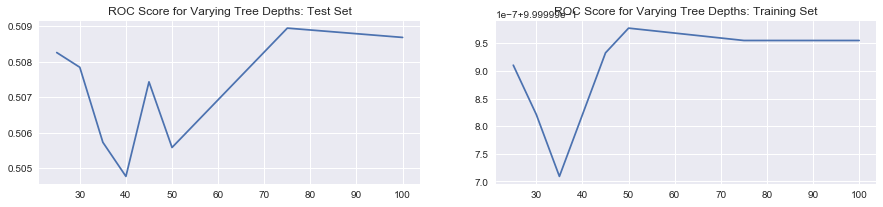

In [26]:
sns.set_context('notebook')
fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].set_title('ROC Score for Varying Tree Depths: Test Set')
ax[0].plot(estimator_number,accuracy_test_cv)
ax[1].set_title('ROC Score for Varying Tree Depths: Training Set')
ax[1].plot(estimator_number,accuracy_train_cv);

The peaks for training and test come around depth = 45.

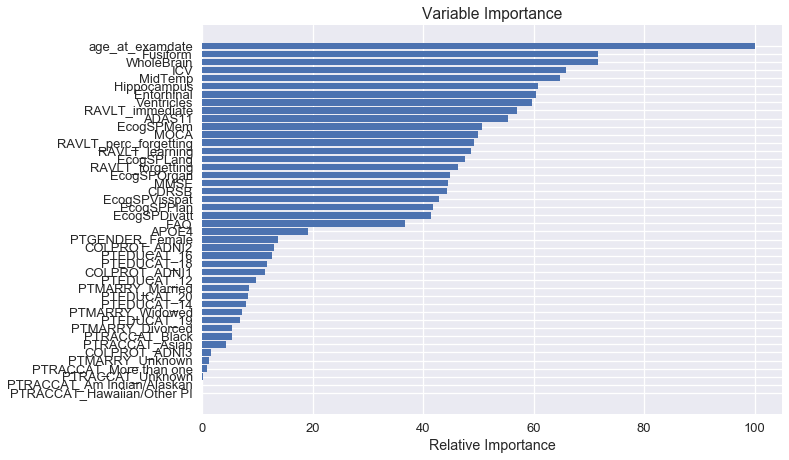

In [27]:
#############################
### Random Forest Model #####
#############################
from sklearn import ensemble
#from lecture 15

rf = ensemble.RandomForestClassifier(max_features= 1, n_estimators=50, oob_score=True)
rf.fit(X_train_risk, y_train_risk)
predict_rf_train = rf.predict_proba(X_train_risk)[:,1]
predict_rf_test = rf.predict_proba(X_test_risk)[:,1]

feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set_context('talk')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_train[risk_predictors].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The greatest predictor by relative importance stands out at age, which is unsurprising for the classification of Alzheimer's. Subsequent variables are based on MRI scans, as well as a few physiological and cognitive factors, which are listed in order of decreasing importance.

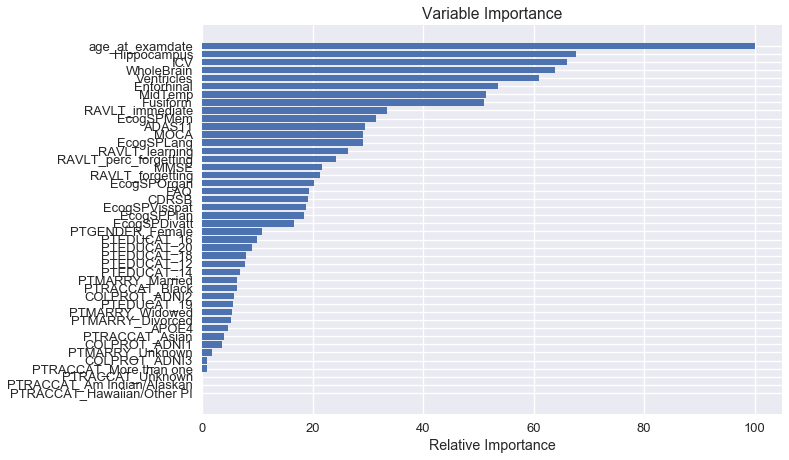

In [28]:
#from lecture 15
bg = ensemble.BaggingClassifier(n_estimators=50, oob_score=True)
bg.fit(X_train_risk, y_train_risk)

predict_bg_train = bg.predict_proba(X_train_risk)[:,1]
predict_bg_test = bg.predict_proba(X_test_risk)[:,1]

feature_importance = np.mean([
    tree.feature_importances_ for tree in bg.estimators_
], axis=0)

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_train[risk_predictors].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Evidently from the graphs above, there is a variation in the relative importance of predictors in the models. This is important to keep in mind as we will later wish to reduce the number of predictors in order to keep our predictive model cost efficient. For instance, many bio-measurements can be costly to record. If they are of significantly low relative importance, then it could be more efficient to simply remove it from our model.

In [29]:
#from lab 9
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)
feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 200
num_steps = 3
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(X_train_risk, y_train_risk)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

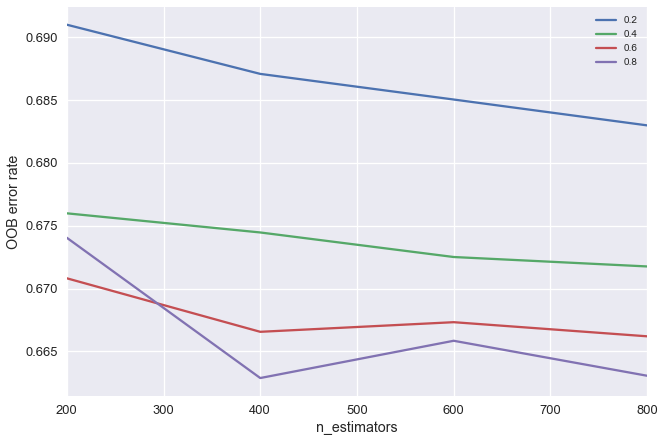

In [30]:
#from lab 9
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
sns.set_context("notebook")
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Thus, from the above, we can see that max features of 0.8 attains the lowest OOB rate (the purple line in the plot, respectively) of approximately 0.660.

In [43]:
##################################
### Summary Scores of Models #####
##################################
# on the train and test set
# Here we use the ROC AUC score instead of accuracy score because the data is unbalanced

print('Logistic Regression model accuracy for training set:', sk.metrics.roc_auc_score(y_train_risk, predict_Logistic_train))
toprint_logit_model = sk.metrics.roc_auc_score(y_test_risk, predict_Logistic_test)
# if lower than 0.5, can simply reverse the predictions to obtain 1 - original score, though this is not optimal
if toprint_logit_model < 0.5:
    toprint_logit_model = (1 - toprint_logit_model)
print('Logistic Regression model accuracy for test set:', toprint_logit_model , '\n')

print('LDA model accuracy for training set:', sk.metrics.roc_auc_score(y_train_risk, predict_LDA_train))
toprint_LDA = sk.metrics.roc_auc_score(y_test_risk, predict_LDA_test)
# if lower than 0.5, can simply reverse the predictions to obtain 1 - original score, though this is not optimal
if toprint_LDA < 0.5:
    toprint_LDA = (1 - toprint_LDA)
print('LDA model accuracy for test set:', toprint_LDA, '\n')

print('QDA model accuracy for training set:', sk.metrics.roc_auc_score(y_train_risk, predict_QDA_train))
print('QDA model accuracy for test set:', sk.metrics.roc_auc_score(y_test_risk, predict_QDA_test), '\n')

print('Decision Tree model (depth ' + str(best_depth) + ') accuracy for training set:', sk.metrics.roc_auc_score(y_train_risk, predict_Tree_train))
toprint_dt = sk.metrics.roc_auc_score(y_test_risk, predict_Tree_test)
# if lower than 0.5, can simply reverse the predictions to obtain 1 - original score, though this is not optimal
if toprint_dt < 0.5:
    toprint_dt = (1 - toprint_dt)
print('Decision Tree model (depth ' + str(best_depth) + ') accuracy for test set:', toprint_dt, '\n')

print('Random Forest model accuracy for training set:', sk.metrics.roc_auc_score(y_train_risk, predict_rf_train))
print('Random Forest model accuracy for test set:', sk.metrics.roc_auc_score(y_test_risk, predict_rf_test), '\n')

print('Bagging model accuracy for training set:', sk.metrics.roc_auc_score(y_train_risk, predict_bg_train))
print('Bagging model accuracy for test set:', sk.metrics.roc_auc_score(y_test_risk, predict_bg_test))


Logistic Regression model accuracy for training set: 0.579215263867
Logistic Regression model accuracy for test set: 0.515109214074 

LDA model accuracy for training set: 0.650891456883
LDA model accuracy for test set: 0.504304304959 

QDA model accuracy for training set: 0.838481870713
QDA model accuracy for test set: 0.512364351035 

Decision Tree model (depth 5) accuracy for training set: 0.70994147312
Decision Tree model (depth 5) accuracy for test set: 0.526975688239 

Random Forest model accuracy for training set: 1.0
Random Forest model accuracy for test set: 0.537548418321 

Bagging model accuracy for training set: 1.0
Bagging model accuracy for test set: 0.529464663823


As noted in a previous section, we focus on the area under the curve instead of the classification accuracy score as our dataset is heavily unbalanced. We can see from the above output that the Random Forest Classifier achieves the highest test set score, followed by Bagging model and Decision Tree model.


Further, we can see that some of the models are heavily overfitted to the training set.

In [32]:
from sklearn.metrics import roc_curve, auc
import seaborn.apionly as sns

#from midterm solutions and lab for pset 6
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else: 
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 4))
            ax.annotate(("t = "+threshold), (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")

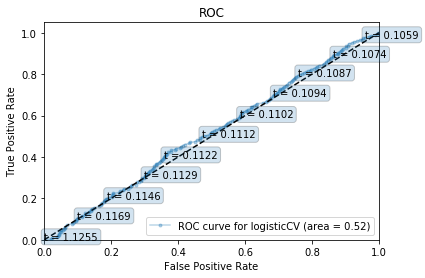

In [33]:
################################
### Plotting the ROC Curve #####
################################
# since originally below biased coin line 
# --> reverse predictions if needed
# y_test_risk = 1 - y_test_risk

#use the labeled roc curve to get a sense of what threshold should be chosen
# using function from Lab 7 / Midterm Solutions, make_roc

ax=make_roc("logisticCV", logit_model, y_test_risk, X_test_risk, labe=100, skip=5)

After trying several different models to find the one(s) that perform best, we further want to account for which can utilize the smallest and least expensive subset of features, as that is the primary challenge in the classification of Alzheimer's.

# Classifying Alzheimer's: Cost Efficiency

Our original goal was to further predict the age at which the onset of Alzheimer's was determined; however, this is not possible given what is provided in the data. Specifically, we have no patients in the data for switching from one classification to another (e.g. from MCI to AD, CN to MCI, or CN to AD), as determined in the beginning of this notebook, so there is no specific information regarding the time at which a person develops Alzheimer's, or changes from CN to AD; therefore, we will now extend our classification model to acknowledge the fact that certain predictors take more time and energy (from both the hospital and the patient) to collect.

Going forward with a classification model, in which the outcome variable represents the likelihood a person with the given values for regressors has Alzheimer's, we explored the estimated costs that each predictor is associated with.  For instance, an MRI measure takes more money and time to collect than demographic data. For both the hos|pital and patient, this is important when considering the cost benefit tradeoffs. Using this cost fuction, we model the tradeoff between an accurate classification and cost, given that metrics such as brain imaging measures and biomarkers are often extremely costly to obtain. We want to find the model with the lowest cost possible by utilizing less expensive features, but also be accurate enough as to not incur misdiagnosis costs.

It is important to note that we estimated costs through online research, but the results of this can differ as costs of each predictor for the hospital of interest vary. Therefore the results of our model are not robust to changes in cost. However, the process of obtaining the results is; therefore simply by changing the cost values used in our algorithm, we can obtain the applicable results.

Given a certain budget, we can determine the optimal predictor categories to use, based on the maximum ROC AUC score on the test set.

In [34]:
#############################################
### Separate Predictors into Categories #####
#############################################


#demographic_predictors =  ['age_at_examdate', 'PTGENDER_Female','PTRACCAT_Am Indian/Alaskan', 'PTRACCAT_Asian','PTRACCAT_Black','PTRACCAT_Hawaiian/Other PI','PTRACCAT_More than one','PTRACCAT_Unknown','PTMARRY_Divorced','PTMARRY_Married','PTMARRY_Unknown','PTMARRY_Widowed','PTEDUCAT_12','PTEDUCAT_14', 'PTEDUCAT_16','PTEDUCAT_18','PTEDUCAT_19','PTEDUCAT_20']
#APOE_predictor = ['APOE']
#ECOG_predictors = ['EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt'] 
#MRI_predictors = ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV']
#indicator_predictor = ['COLPROT_ADNI1','COLPROT_ADNI2','COLPROT_ADNI3']
#CDRSB_predictor = ['CDRSB']
#ADAS11_predictor = ['ADAS11']
#MMSE_predictor = ['MMSE']
#RAVLT_predictor = ['RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting']
#FAQ_predictor = ['FAQ']
#MOCA_predictor = ['MOCA']


predictor_categories_dict = {'demographic_predictors': ['age_at_examdate', 'PTGENDER_Female','PTRACCAT_Am Indian/Alaskan', 'PTRACCAT_Asian','PTRACCAT_Black','PTRACCAT_Hawaiian/Other PI','PTRACCAT_More than one','PTRACCAT_Unknown','PTMARRY_Divorced','PTMARRY_Married','PTMARRY_Unknown','PTMARRY_Widowed','PTEDUCAT_12','PTEDUCAT_14', 'PTEDUCAT_16','PTEDUCAT_18','PTEDUCAT_19','PTEDUCAT_20'], 'APOE_predictor' : ['APOE4'],'ECOG_predictors' : ['EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt'] ,'MRI_predictors' : ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV'],'indicator_predictor' : ['COLPROT_ADNI1','COLPROT_ADNI2','COLPROT_ADNI3'],'CDRSB_predictor' : ['CDRSB'],'ADAS11_predictor' : ['ADAS11'],'MMSE_predictor' : ['MMSE'], 'RAVLT_predictor' : ['RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting'], 'FAQ_predictor' : ['FAQ'], 'MOCA_predictor' : ['MOCA']}



In [35]:
predictor_categories = ['demographic_predictors', 'APOE_predictor', 'ECOG_predictors', 'MRI_predictors', 'indicator_predictor','CDRSB_predictor', 'ADAS11_predictor', 'MMSE_predictor', 'RAVLT_predictor', 'FAQ_predictor', 'MOCA_predictor']



We assign a unique cost to groups of predictors. The intuition behind this is that many predictors have a fixed base cost, and once one variable in a group is collected, the cost to collect the rest is trivial. For instance, in once a single predictor that requires an MRI is used, then the cost of using an MRI is paid, and then the additional cost of the other MRI predictors becomes trivial. While this can be an oversimplification of cost, this simple model provides a rough estimated cost benefit analysis.

In [36]:
###########################################
### Dictionary of Costs of Predictors #####
###########################################

# if costs differ for a given hopsital, this is the section that would be changed
#cost_demographic_predictors = 0
#cost_APOE_predictor = 1000
#cost_ECOG_predictors = 10
#cost_MRI_predictors = 3000
#cost_indicator_predictor = 0

#cost_CDRSB_predictor = 50
#cost_ADAS11_predictor = 175
#cost_MMSE_predictor = 125
#cost_RAVLT_predictor = 100
#cost_FAQ_predictor = 5
#cost_MOCA_predictor = 150


predictor_categories_costs_dictionary = {'cost_demographic_predictors': 0, 'cost_APOE_predictor' : 1000, 'cost_ECOG_predictors': 10, 'cost_MRI_predictors': 3000, 'cost_indicator_predictor': 0,'cost_CDRSB_predictor' : 50, 'cost_ADAS11_predictor' : 175,'cost_MMSE_predictor' : 125,'cost_RAVLT_predictor' : 100, 'cost_FAQ_predictor' : 5,'cost_MOCA_predictor' : 150}



In [37]:
################################################################
### Get Every Possible Combination of Predictor Categories #####
################################################################

# code from https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
import itertools
category_combinations = []
for L in range(0, len(predictor_categories)+1):
  for subset in itertools.combinations(predictor_categories, L):
    category_combinations.append(list(subset))
print('Number of unique combinations of predictor categories:', len(category_combinations))

Number of unique combinations of predictor categories: 2048


Now we fit an LDA model onto each unique combination of the predictor categories and compute the cost for each one. 

In [38]:
##########################################################################
### Fit Model for Every Possible Combination of Predictor Categories #####
##########################################################################

#use LDA for now

category_set_costs = []
category_set_scores_train = []
category_set_scores_test = []


# for every category set
for category_set in category_combinations[1:]:
    list_of_variables = []
    for each_category in category_set:
        list_of_variables= list_of_variables+ predictor_categories_dict[each_category]
    #make training and test set using the predictors of the categories
    all_vars_in_model = list_of_variables + ['got_alz']
    df_train_use = df_train[all_vars_in_model].dropna(axis=0, how='any')
    df_test_use = df_test[all_vars_in_model].dropna(axis=0, how='any')
    
    X_train = df_train_use[list_of_variables].values
    X_test = df_test_use[list_of_variables].values
    y_train_risk = df_train_use['got_alz'].values
    y_test_risk = df_test_use['got_alz'].values
    
    #fit the model
    lda.fit(X_train, y_train_risk)
    # append the scores of model for train and test
    category_set_scores_train.append(sk.metrics.roc_auc_score(y_train_risk, lda.predict_proba(X_train)[:,1]))
    category_set_scores_test.append(sk.metrics.roc_auc_score(y_test_risk, lda.predict_proba(X_test)[:,1]))
    #calculate cost of category set
    #can get variable names for costs by adding 'cost_' for each one
    #make list of each cost variable that corresponds to this set
    costvariables_in_category_set = []
    for var_name in category_set:
        costvariables_in_category_set.append('cost_' + str(var_name))
    cost = 0
    for each_cost in costvariables_in_category_set:
        cost = cost + predictor_categories_costs_dictionary[each_cost]
    category_set_costs.append(cost)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [39]:
category_set_costs_copy, category_set_scores_train = zip(*sorted(zip(category_set_costs, category_set_scores_train)))
category_set_costs_copy, category_set_scores_test = zip(*sorted(zip(category_set_costs, category_set_scores_test)))
category_set_costs_copy, category_set_sorted = zip(*sorted(zip(category_set_costs, category_combinations[1:])))

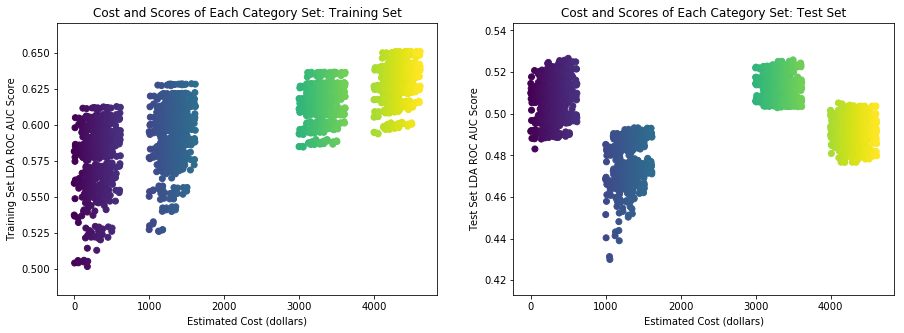

In [40]:
##############################################
## Plot Findings: Training Set and Test Set ##
##############################################
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(category_set_costs_copy, category_set_scores_train, c = category_set_costs_copy)
ax[0].set_title('Cost and Scores of Each Category Set: Training Set')
ax[0].set_xlabel('Estimated Cost (dollars)')
ax[0].set_ylabel('Training Set LDA ROC AUC Score')

ax[1].scatter(category_set_costs_copy, category_set_scores_test, c = category_set_costs_copy)
ax[1].set_title('Cost and Scores of Each Category Set: Test Set')
ax[1].set_xlabel('Estimated Cost (dollars)')
ax[1].set_ylabel('Test Set LDA ROC AUC Score')
plt.show()

From the above graph we can see that for every small range of cost, there is a huge variation in the ROC AUC score for the test and training sets. Each point in this scatterplot represents a unique combination of predictor categories. The x-axis is the estimated cost in dollars associated with each predictor category set, which is calculated from the price estimations as explained above. The y-axis is the test set ROC AUC score of the corresponding LDA model using the corresponding set of predictors, which we determined by running the LDA model using the preditors as defined by each observation. We used the LDA model in this section because we determined it as the optimal in the previous section, but this cost-benefit analysis be repeated using a different model. Further, we choose ROC AUC score to acnowledge the fact that our dataset is unbalanced, but could also have used other scoring methods such as accuracy score.

There appear to be clusters in our output because the prices of our predictor categories are not continuous, and we only have a specified number of predictor categories. Therefore the clusters result because there are only a certain range of possible estimated costs given the way we defined the costs (prices) of our predictor categories. Therefore left-most cluster corresponds to the sets of predictor categories that cost the least (i.e. do not include MRI), while those in the right-most cluster are the most expensive sets of predictor categories.

As we would expect from overfitting, we see that the ROC AUC scores are generally higher for the training set than for the test set. This is particularly the case as estimated cost increases, which follows intuition since a greater cost weakly corresponds to a greater number of predictors. We can think about the most expensive set of predictors; this would be the entire set of all possible predictors. On the other hand, the least expensive set of predictors would be a set of the single most cheapest predictor set. Therefore going from the cheapest set to the most expensive has a weak positive relationship with the number of predictors; we say weakly because a single predictor category, such as MRI, can be more expensive than multiple cheap ones combined and therefore it is not a perfect correlation.

The color gradient of the observations correspond to the estimated cost, such that the lighter colors are more expensive observations and the darker ones are cheaper. While it would take too long to list each of set of predictor categories that corresponds to the observations, we can easily find the set of predictor categories if we have a certain test score and estimated cost in mind. For instance, if we define our estimated budget then we can compare models from in a specfic range of estimated cost, and select the observation with the highest test set ROC AUC score, and choose the set of predictor categories that correspond to that observation.

In [41]:
###########################################
## Make Our Output Data into Dataframe ####
###########################################

df_predictor_costs = pd.DataFrame(data= {'predictors': category_set_sorted, 'cost' : category_set_costs_copy, 'scores_train': category_set_scores_train, 'scores_test': category_set_scores_test })
df_predictor_costs.head()

,cost,predictors,scores_test,scores_train
0,0,[demographic_predictors],0.491495,0.537405
1,0,"[demographic_predictors, indicator_predictor]",0.510054,0.559492
2,0,[indicator_predictor],0.514540,0.581604
3,5,[FAQ_predictor],0.491825,0.504102
4,5,"[demographic_predictors, FAQ_predictor]",0.507174,0.536640


Now, using this dataframe, we can select the best predictor given a budget.

In [42]:
#########################################
## Choosing Predictors Based on Budget ##
#########################################

budget = 2000

max_testscore_given_budget = max(df_predictor_costs[df_predictor_costs['cost'] < budget].scores_test)
index_predictor = int(df_predictor_costs[df_predictor_costs['scores_test'] == max(df_predictor_costs[df_predictor_costs['cost'] < budget].scores_test)].index.values)

print('predictors categories to use with given budget:', '\n', df_predictor_costs['predictors'][index_predictor])

predictors categories to use with given budget: 
 ['indicator_predictor', 'CDRSB_predictor', 'ADAS11_predictor', 'MMSE_predictor', 'MOCA_predictor']


Thus, given a budget of only \$2000, we see that the above predictors would be utilized. The budget can be reset and adjusted, with the cost on a per-classification basis.